In [1]:
import sys, os
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../')))
from stochss_compute.cloud.ec2 import Cluster
import gillespy2
import numpy

In [2]:
class MichaelisMenten(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Michaelis_Menten")
            
            ''' 
            PARAMETERS:
            These are constant values relevant to the system, such as reaction kinetic rates.
            
            name: user defined name for reference
            expression: constant value
            '''
            rate1 = gillespy2.Parameter(name='rate1', expression= 0.0017)
            rate2 = gillespy2.Parameter(name='rate2', expression= 0.51)
            rate3 = gillespy2.Parameter(name='rate3', expression = 0.11)
            
            # Add parameters to the model
            self.add_parameter([rate1,rate2,rate3])
            
            '''
            SPECIES:
            These can be anything that participates in or is produced by a reaction channel.
            
            name: A user defined name for the species
            initial_value: value/population count of species at start of simulation
            '''
            A = gillespy2.Species(name='A', initial_value=301)
            B = gillespy2.Species(name='B', initial_value=121)
            C = gillespy2.Species(name='C', initial_value=0)
            D = gillespy2.Species(name='D', initial_value=0)
            
            # Add species to the model
            self.add_species([A, B, C, D])
            
            '''Reactions:
            These are the reaction channels causing the system to change over time
            
            name: a user defined name for the reaction
            reactants: dictionary with participant reactants as keys, and consumed per reaction as value.
            products: dictionary with reaction products as keys, and number formed per reaction as value.
            rate: parameter rate constant to be applied to the propensity of this reaction firing
            propensity_function: can be used instead of rate in order to declare a custom propensity function in string format'''
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={C:1},
                   rate=rate1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={C:1}, products={A:1,B:1},
                    rate=rate2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={C:1}, products={B:1,D:1},
                    rate=rate3)
            
            # Add reactions to the model
            self.add_reaction([r1,r2,r3])
            
            # Set timespan of model
            self.timespan(numpy.linspace(0,101,102))
myModel = MichaelisMenten()

In [3]:
cluster = Cluster()

In [4]:

cluster.launch_single_node_cluster()

Launching StochSS-Compute server instance.......(This could take a minute)
Instance "i-00e4f7e9d4f85aede" is running.


ec2.Instance(id='i-00e4f7e9d4f85aede')

In [5]:
from time import sleep
from paramiko import SSHClient, AutoAddPolicy

In [6]:
ssh = SSHClient()
ssh.set_missing_host_key_policy(AutoAddPolicy())
while True:
    try:
        ssh.connect(cluster._server.public_ip_address, username='ec2-user', key_filename=cluster._key_path, look_for_keys=False)
        break
    except:
        sleep(5)
        continue

In [23]:
stdin,stdout,stderr=ssh.exec_command("docker container inspect -f '{{.State.Running}}' sssc")
# stdin,stdout,stderr=ssh.exec_command("docker ps")
rc = stdout.channel.recv_exit_status()
stdout.readlines()

['true\n']

In [24]:
results = cluster.run(myModel)

[SourceIpRequest] http://3.145.146.159:29681/api/v1/cloud/sourceip
[ModelRunRequest] http://3.145.146.159:29681/api/v1/gillespy2/model/run


[GET] http://3.145.146.159:29681/api/v1/job/ffcb4f381e15e38fe707840023301b1b-run_1/status
The job is complete.
4
[GET] http://3.145.146.159:29681/api/v1/memory/ffcb4f381e15e38fe707840023301b1b-run_1/get
Results size: 2129
Expanded to: 37229


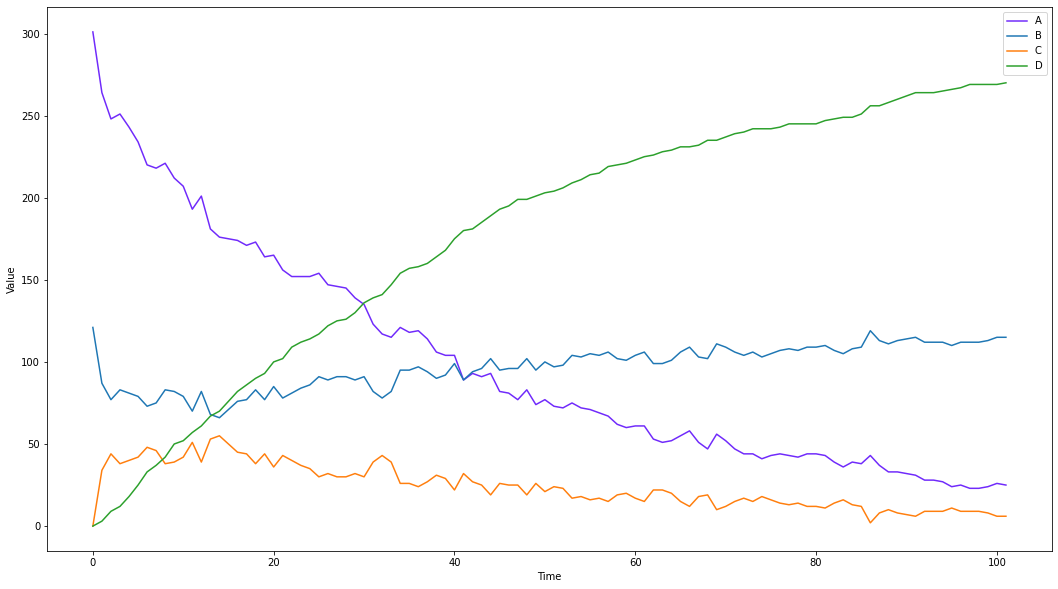

In [25]:
results = results.resolve()

results.plot()

In [26]:
cluster.clean_up()

Terminating "i-00e4f7e9d4f85aede". This might take a minute.......
Instance i-00e4f7e9d4f85aede" terminated.
Deleting sg-02cea3a720e053dd8.......
Security group sg-02cea3a720e053dd8 deleted.
Deleting subnet-0ad1be7754683ae8b.......
Subnet subnet-0ad1be7754683ae8b deleted.
Detaching igw-09e7ad864931a2cbf.......
Gateway igw-09e7ad864931a2cbf detached.
Deleting igw-09e7ad864931a2cbf.......
Gateway igw-09e7ad864931a2cbf deleted.
Deleting vpc-09ad057f4e280e779.......
VPC vpc-09ad057f4e280e779 deleted.
Deleting key-07cb12da2c145e66a.......
Root key deleted.
